In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B, GradientDescent, ADAM
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit.circuit import Parameter
from qiskit.primitives import StatevectorEstimator as Estimator

algorithm_globals.random_seed = 42

In [3]:
num_inputs = 1 # num of features (p)
num_samples = 30 # num of instances (n)

In [4]:
# Points entre -2 et 2 sur un seul axe
X = 4 * algorithm_globals.random.random([num_samples, 1]) - 2  
X_test = 4 * algorithm_globals.random.random([10, 1]) - 2

# Bleu si entre -1 et 1, rouge sinon
y = np.where((X >= -1) & (X <= 1), 1, -1).flatten() 
y_test = np.where((X_test >= -1) & (X_test <= 1), 1, -1).flatten()

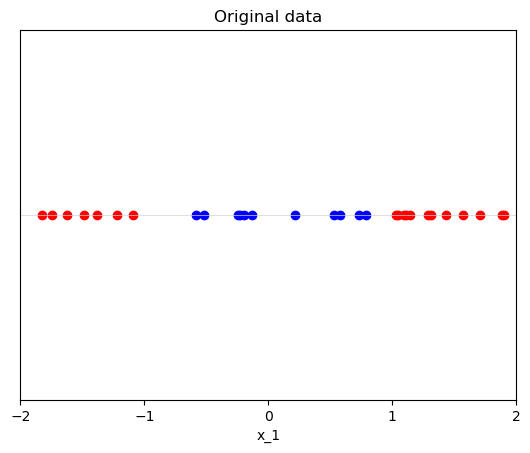

In [5]:
# On plot la distribution
for x_i, y_i in zip(X, y):
    if y_i == 1:
        plt.plot(x_i[0], 0, "bo") 
    else:
        plt.plot(x_i[0], 0, "ro")

plt.axhline(0, color="lightgray", linewidth=0.5)
plt.title("Original data")
plt.xlabel("x_1")
plt.xticks([-2, -1, 0, 1, 2])
plt.yticks([])
plt.xlim(-2, 2)
plt.show()

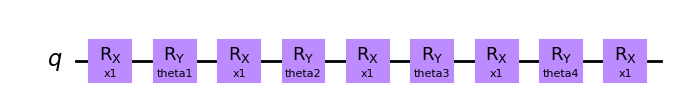

In [6]:
# Le circuit contient 1 input et 4 paramètres à entrainer
params = [Parameter("x1"), Parameter("theta1"), Parameter("theta2"), Parameter("theta3"), Parameter("theta4")]
# Le circuit utilise un seul qubit
qcc = QuantumCircuit(1) 
# On suit l'architecture du papier
qcc.rx(params[0], 0)
qcc.ry(params[1], 0)
qcc.rx(params[0], 0)
qcc.ry(params[2], 0)
qcc.rx(params[0], 0)
qcc.ry(params[3], 0)
qcc.rx(params[0], 0)
qcc.ry(params[4], 0)
qcc.rx(params[0], 0)

qcc.draw("mpl", style="clifford")

In [7]:
# On prépare notre Estimator
estimator = Estimator()
estimator_qnn = EstimatorQNN(
    circuit=qcc, 
    estimator=estimator,
    input_params=[params[0]], 
    weight_params=[params[1], params[2], params[3], params[4]],
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [8]:
# On définit une callback function pour monitorer l'entrainement
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [9]:
# On prépare le classifier avec le circuit à entrainer et l'optimizer
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, 
    optimizer=COBYLA(maxiter=6), 
    callback=callback_graph
)

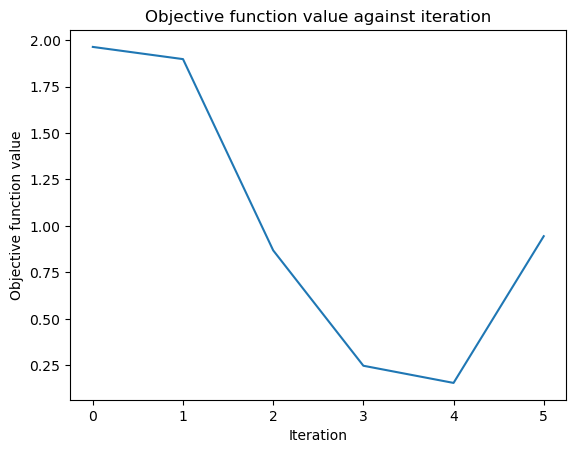

1.0

In [10]:
# On crée un array vide to stocker les valeurs de la loss pendant l'entrainement
objective_func_vals = []
# On fit le modèle aux données
estimator_classifier.fit(X, y)
# On affiche l'accuracy
estimator_classifier.score(X, y)

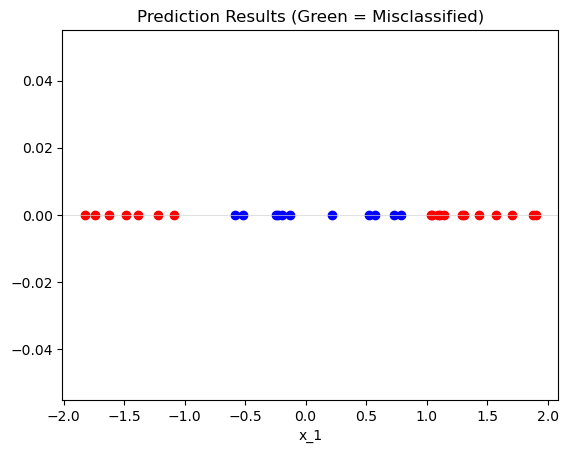

In [15]:
# On génère les valeurs prédites
y_predict = estimator_classifier.predict(X)

# On plot le résultat
# Red circles indicate misclassified points
for x, y_target, y_p in zip(X, y, y_predict):
    if y_p == 1:
        plt.plot(x[0], 0, "bo") 
    else:
        plt.plot(x[0], 0, "ro")
    
    # On entoure les instances mal classifiées en vert
    if y_target != y_p:
        plt.scatter(x[0], 0, s=200, facecolors="none", edgecolors="g", linewidths=2)

plt.axhline(0, color="lightgray", linewidth=0.5)
plt.title("Prediction Results (Green = Misclassified)")
plt.xlabel("x_1")
plt.show()

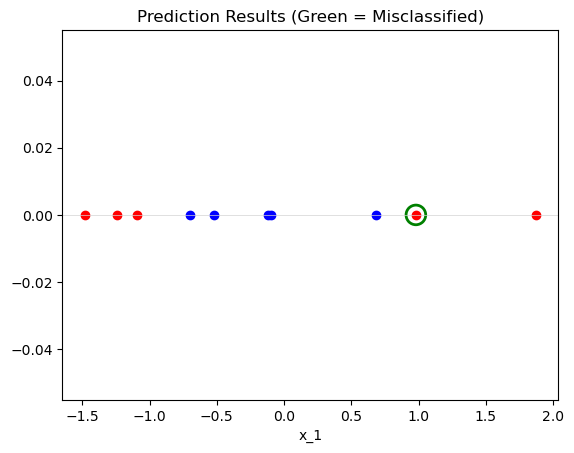

Score sur les données de test: 0.9


In [17]:
# On génère les valeurs prédites
y_predict_test = estimator_classifier.predict(X_test)

# On plot le résultat
# Red circles indicate misclassified points
for x, y_target, y_p in zip(X_test, y_test, y_predict_test):
    if y_p == 1:
        plt.plot(x[0], 0, "bo") 
    else:
        plt.plot(x[0], 0, "ro")
    
    # On entoure les instances mal classifiées en vert
    if y_target != y_p:
        plt.scatter(x[0], 0, s=200, facecolors="none", edgecolors="g", linewidths=2)

plt.axhline(0, color="lightgray", linewidth=0.5)
plt.title("Prediction Results (Green = Misclassified)")
plt.xlabel("x_1")
plt.show()
score_test = estimator_classifier.score(X_test, y_test)
print(f"Score sur les données de test: {score_test}")

In [85]:
# On affiche les valeurs des theta_i
estimator_classifier.weights

array([-0.61512483, -0.0938694 ,  0.03895692,  0.72362907])